CSCI P-556: Applied Machine Learning

Fall 2019

Assignment 4

Due: 11:59PM, December 6, 2019

Read dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
#reading data in train and test
train = pd.read_csv('a4-train.csv', index_col=0, low_memory = False)
test = pd.read_csv('a4-test.csv', index_col=0)

In [3]:
train.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_491,feat_492,feat_493,feat_494,feat_495,feat_496,feat_497,feat_498,feat_499,labels
0,485,423,504,493,521,466,494,479,482,471,...,478,479,567,547,498,484,474,567,538,0
1,483,499,520,467,495,484,485,477,488,491,...,481,484,451,445,443,481,485,492,477,1
2,487,486,495,481,421,481,499,478,489,482,...,477,511,245,522,480,483,493,421,488,1
3,480,427,531,458,544,492,489,477,478,482,...,483,471,313,490,414,480,516,495,469,0
4,491,472,430,463,431,480,459,477,481,479,...,479,493,435,444,455,482,468,497,435,1


Task 1: Perform exploratory data analysis (15 points)

In [4]:
# description of the first column of the training data
train['feat_0'].describe()

count    2000.000000
mean      481.722500
std         6.421769
min       462.000000
25%       477.000000
50%       482.000000
75%       486.000000
max       503.000000
Name: feat_0, dtype: float64

In [5]:
print(train.columns.dtype)

object


In [6]:
# checking for duplicate rows in the data
duplicate_rows_df = train[train.duplicated()]
print( "number of duplicate rows:", duplicate_rows_df.shape[0])

number of duplicate rows: 0


In [7]:
# Even if there are no duplicate rows, we will check for duplicate columns 
for col in train.columns:
    for col2 in train.columns:
        if col != col2:
            if train[col].equals(train[col2]):
                print(col,"and",col2,"are equal")

In [8]:
# separate X and y data
X_train = train.iloc[:,:500]
y_train= train.iloc[:,-1]
X_test = test.iloc[:,:500]
y_test= test.iloc[:,-1]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000, 500)
(600, 500)
(2000,)
(600,)


In [10]:
# number of null values in the df
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [11]:
y_train.unique()

array([0, 1])

In [12]:
y_train.value_counts()

1    1000
0    1000
Name: labels, dtype: int64

(array([ 14.,  71., 185., 337., 493., 455., 271., 124.,  41.,   9.]),
 array([462. , 466.1, 470.2, 474.3, 478.4, 482.5, 486.6, 490.7, 494.8,
        498.9, 503. ]),
 <a list of 10 Patch objects>)

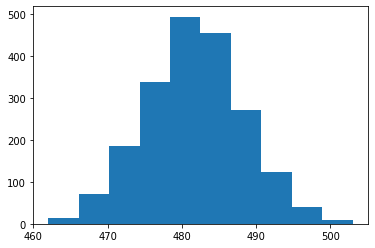

In [13]:
# to understand the distribution of the data
plt.hist(X_train['feat_0'])

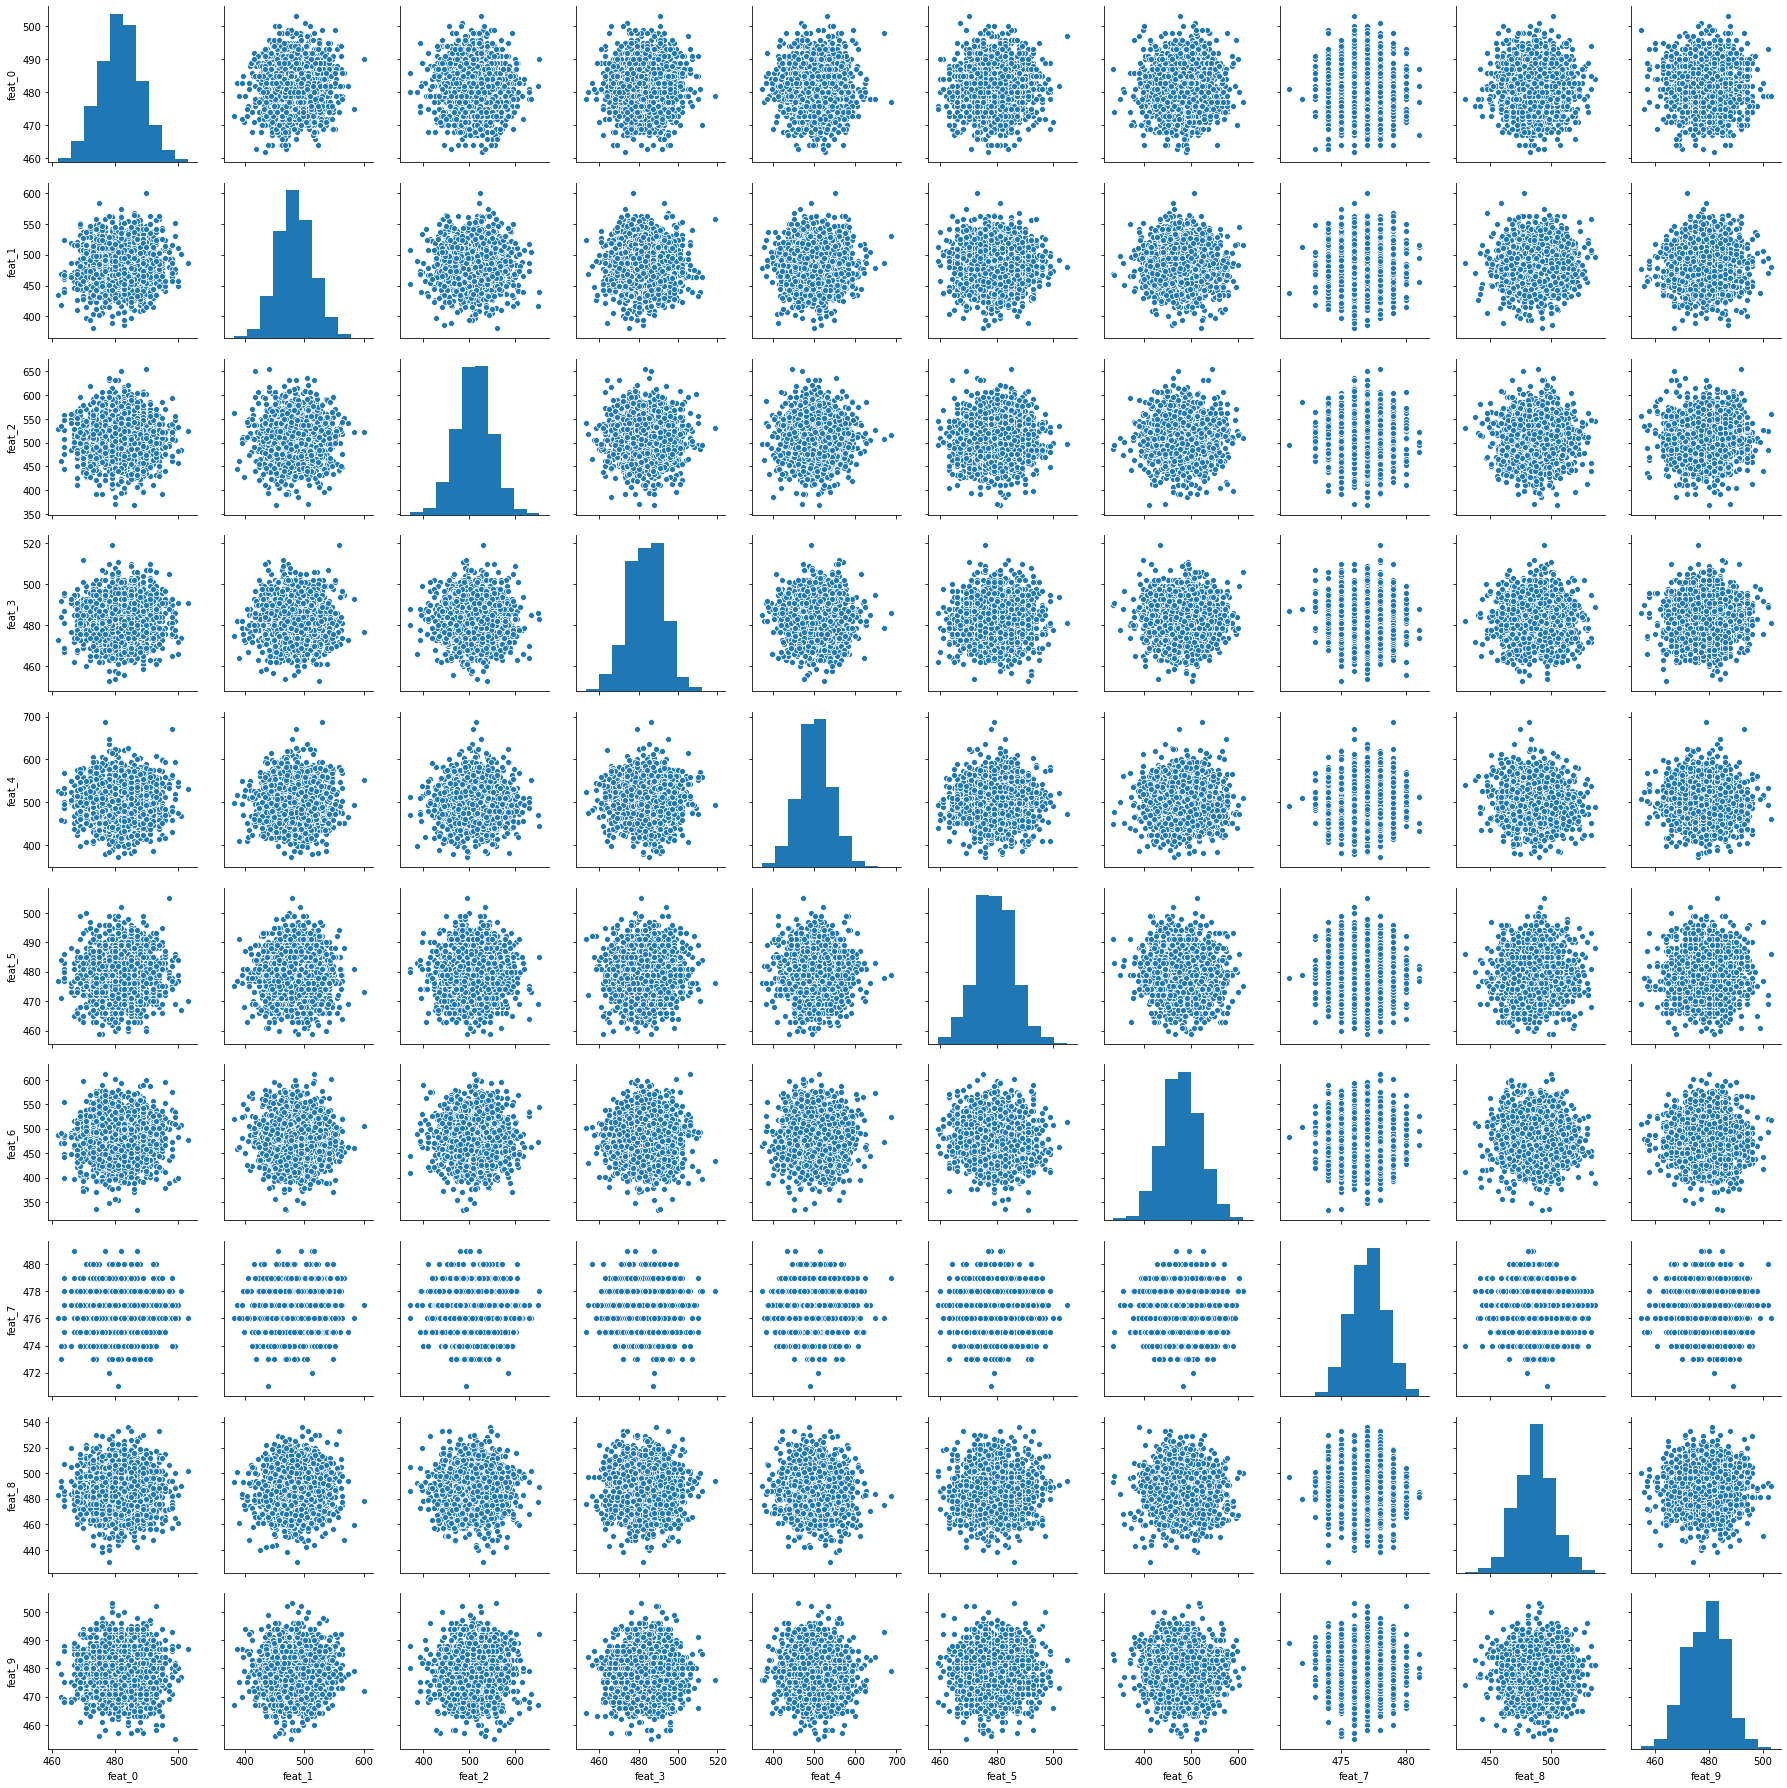

In [14]:
# Checking correlation of columns with each other

sns.pairplot(X_train.iloc[:,:10])

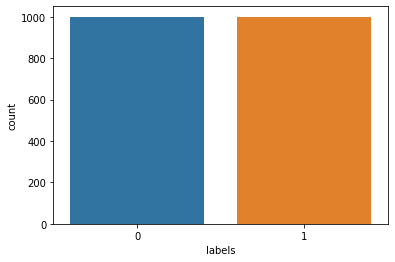

In [15]:
# counts of number of samples in each class for train data
sns.countplot(y_train)

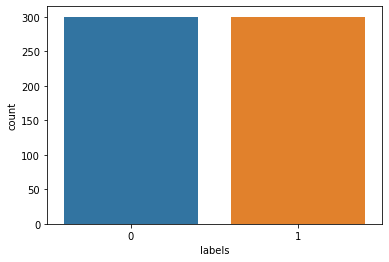

In [16]:
# counts of number of samples in each class for test data
sns.countplot(y_test)

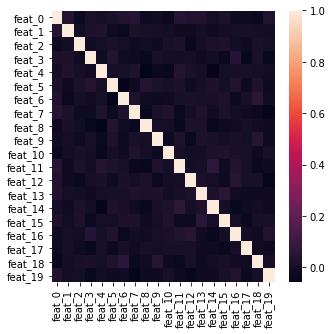

In [17]:
# correlation using heatmap
f, ax = plt.subplots(figsize=(5, 5))
corr = train.iloc[:,:20].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


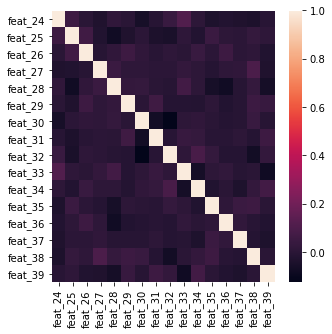

In [18]:
f, ax = plt.subplots(figsize=(5, 5))
corr = test.iloc[:,24:40].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


Task 2: Use scikit-learn's logistic regression to establish a baseline model. We are not expecting this model to perform well, we just want to know what is the highest accuracy that we can achieve without doing any feature engineering and/or parameter tuning. (5 points)

In [19]:
# baseline logistic regression model
clf = LogisticRegression()

In [20]:
clf.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
y_pred = clf.predict(X_test)

In [22]:
# confusion matrix
def confusion_mat(y_test, y_pred):
    c = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['0','1'], columns = ['0', '1'])
    print(c)

In [23]:
confusion_mat(y_test, y_pred)

     0    1
0  180  120
1  126  174


In [24]:
score = clf.score(X_test, y_test)
print(score * 100)

59.0


Task 3: Feature engineering. On this task you'll write code to modify your features such that the model can achieve a higher accuracy. You are free to modify the data as you want, but a rationale has to be provided for each modification. Additionally, if you are using anything that has not been convered in class, write a brief description of how the function works. Note that copy/pasting a function's docstring is not what we are asking and we will take off points if this is what you do. (20 points)

In [25]:
def normalize(df):
    x = df.values
    std_scaler = preprocessing.StandardScaler()
    x_scaled = std_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

In [26]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [27]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.510501,-2.003148,-0.158552,1.061591,0.468534,-1.951501,0.342419,1.759247,-0.318715,-1.083442,...,-0.596534,-0.202332,-0.307015,0.551979,1.536915,-0.344272,0.983222,-0.686684,1.586001,1.848807
1,0.198982,0.515180,0.252871,-1.808917,-0.159803,0.697795,0.120557,0.314280,0.080219,1.698538,...,-1.793576,0.545661,-0.098346,-0.357087,-1.393251,-1.812898,0.472943,0.124738,-0.429316,-0.513811
2,0.822020,0.084414,-0.389977,-0.263259,-1.948147,0.256246,0.465676,1.036763,0.146708,0.446647,...,0.169573,-0.451663,1.028468,-1.971462,0.818737,-0.824913,0.813129,0.714862,-2.337150,-0.087765
3,-0.268295,-1.870605,0.535724,-2.802554,1.024371,1.875260,0.219163,0.314280,-0.584671,0.446647,...,1.079325,1.044323,-0.640886,-1.438561,-0.100531,-2.587264,0.302850,2.411471,-0.348704,-0.823663
4,1.445057,-0.379489,-2.061382,-2.250534,-1.706479,0.109063,-0.520377,0.314280,-0.385204,0.029350,...,0.169573,0.046999,0.277259,-0.482475,-1.421978,-1.492470,0.643036,-1.129277,-0.294962,-2.140532


#### Feature importance

I train a random forest with some hyper parameter tuning. Then I use the best of those to do feature importance on the columns.

Feature importance: We train a rf on the data and get the accuracy. Then one by one we randomly shuffle the cols and see how much the accuracy changes. If it changes a lot, it means the column is really important. We then remove the cols which are not really important.

We do this instead of dropping one column every time because that would require retraining model. This saves time and resources.

I am dropping around 400 columns

In [28]:
def randomfor(n_estimators = 150, max_features='auto', min_samples_leaf = 1):

    rf = RandomForestClassifier(n_estimators = n_estimators,max_features =max_features, min_samples_leaf = min_samples_leaf)
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    print(score * 100)

In [29]:
randomfor(100)

72.83333333333334


In [30]:
randomfor(150)

71.33333333333334


In [31]:
randomfor(200)

71.83333333333334


In [32]:
randomfor(150, 30)

74.16666666666667


In [33]:
randomfor(150, 50)

78.83333333333333


In [34]:
randomfor(150, 50, 10)

78.0


In [35]:
randomfor(170, 50, 10)

78.33333333333333


In [36]:
randomfor(150, 60, 10)

79.33333333333333


In [37]:
rf = RandomForestClassifier(n_estimators=150, max_features=60, min_samples_leaf=10)

In [38]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=60, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [40]:
X = X_train.copy()
Xt = X_test.copy()

In [41]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.510501,-2.003148,-0.158552,1.061591,0.468534,-1.951501,0.342419,1.759247,-0.318715,-1.083442,...,-0.596534,-0.202332,-0.307015,0.551979,1.536915,-0.344272,0.983222,-0.686684,1.586001,1.848807
1,0.198982,0.515180,0.252871,-1.808917,-0.159803,0.697795,0.120557,0.314280,0.080219,1.698538,...,-1.793576,0.545661,-0.098346,-0.357087,-1.393251,-1.812898,0.472943,0.124738,-0.429316,-0.513811
2,0.822020,0.084414,-0.389977,-0.263259,-1.948147,0.256246,0.465676,1.036763,0.146708,0.446647,...,0.169573,-0.451663,1.028468,-1.971462,0.818737,-0.824913,0.813129,0.714862,-2.337150,-0.087765
3,-0.268295,-1.870605,0.535724,-2.802554,1.024371,1.875260,0.219163,0.314280,-0.584671,0.446647,...,1.079325,1.044323,-0.640886,-1.438561,-0.100531,-2.587264,0.302850,2.411471,-0.348704,-0.823663
4,1.445057,-0.379489,-2.061382,-2.250534,-1.706479,0.109063,-0.520377,0.314280,-0.385204,0.029350,...,0.169573,0.046999,0.277259,-0.482475,-1.421978,-1.492470,0.643036,-1.129277,-0.294962,-2.140532


In [42]:
X.shape, Xt.shape

((2000, 500), (600, 500))

In [43]:
keep = []
for i in range(X_train.shape[1]):
    if importances[indices[i]] >= 0.0016:
        keep.append(indices[i])

In [44]:
len(keep)

93

In [45]:
X = X.loc[:,keep]
Xt = Xt.loc[:,keep]

In [46]:
X.head()

,475,338,105,241,472,48,378,442,128,318,...,419,218,319,303,255,32,244,41,331,89
0,-0.984847,0.655397,1.106980,-0.966072,0.778534,0.930223,0.870766,0.701306,1.293570,1.153710,...,0.958405,0.805516,-0.206285,-0.357492,-0.183985,1.281863,-0.798936,-1.874327,0.439616,0.863438
1,-0.528470,0.841097,0.095985,-0.556115,0.283541,0.790687,0.801843,0.156387,0.076420,0.464928,...,-1.148982,1.684440,0.410583,-0.316935,-1.761871,1.060807,-2.720332,-0.193525,0.439616,1.050590
2,1.297035,-0.138986,0.162889,1.680011,-1.336436,0.348826,0.388309,-1.570905,0.076420,1.089137,...,-0.152244,-0.476249,-0.366214,-1.858112,-0.634809,-0.431322,-1.204865,0.039201,-1.153058,-0.891113
3,0.719853,0.655397,-0.691996,0.990539,-0.166453,0.441850,0.422770,-0.172621,-0.619095,-0.611294,...,-0.750287,0.256188,1.027450,-1.452539,-1.150038,0.563431,-0.744812,0.711522,0.894666,2.711564
4,-1.065384,2.027512,-1.829366,-1.077878,1.183528,-1.093037,-1.110754,1.081722,-2.010124,-0.955685,...,1.471013,1.281600,1.918482,1.143127,-0.699213,0.895015,-1.042493,1.926871,-1.228900,-0.867719


Task 4: Model building & evaluation. Train at least 4 models:


1.   Neural network (any type of NN is fine)
2.   Decision tree (can be a plain decision tree, random forest, gradient boosted trees, etc.)
3.   Support vector machine
4.   Your choice of Naive Bayes or K-nearest neighbors

For model 4, briefly (no more than 2 paragraphs) describe how the model works. 

Part of your grade will depend on how your best model performs against the best model of all the classmates, as determined by the accuracy achieved using the test set. You are encouraged to share your best model's accuracy on Piazza, but not which feature engineering or model tuning steps you took to achieve it. (60 points)

### Model 1 : Neural network

In [47]:
clf = MLPClassifier(solver = 'lbfgs', alpha=1e-4, hidden_layer_sizes=(100, 2),early_stopping=True, random_state=2)



In [48]:
clf.fit(X, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [49]:
score = clf.score(Xt, y_test)
print(score * 100)

67.0


In [50]:
y_pred = clf.predict(Xt)
confusion_mat(y_test, y_pred)

     0    1
0  218   82
1  116  184


### Model 2 : Random forest

This is my best performing model and I get an accuracy of around 88% by using just 100 columns approximately.

In [51]:
rf = RandomForestClassifier(n_estimators=150, max_features=50, min_samples_leaf=10)

In [52]:
rf.fit(X, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
score = rf.score(Xt, y_test)
print(score * 100)

86.16666666666667


In [54]:
y_pred = rf.predict(Xt)
confusion_mat(y_test, y_pred)

     0    1
0  253   47
1   36  264


### Model 3 : SVM

In [55]:
sm = SVC()

In [56]:
sm.fit(X, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [57]:
score = sm.score(Xt, y_test)

In [58]:
print(score*100)

67.83333333333333


In [59]:
y_pred = sm.predict(Xt)
confusion_mat(y_test, y_pred)

     0    1
0  203   97
1   96  204


### Model 4 : KNN

In [60]:
neighbour = KNeighborsClassifier(n_neighbors=11, p=1)
neighbour.fit(X, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=1,
                     weights='uniform')

In [61]:
y_pred = neighbour.predict(Xt)

In [62]:
print(accuracy_score(y_test, y_pred)*100)

78.66666666666666


In [63]:
score = neighbour.score(Xt,y_test)

In [64]:
print(score*100)

78.66666666666666


In [65]:
y_pred = neighbour.predict(Xt)
confusion_mat(y_test, y_pred)

     0    1
0  233   67
1   61  239


The K Nearest Neighbours Algorithm is a supervised learning algorithm. So, we train it on labelled input data and we send unlabelled test data. The task is to assign classes to the unlabelled data. The logic K nearest Neighbours follows is, similar groups of data are closer to each other. So, if we count the number of neighbours for a new(unlabelled) point, the number of neighbours it has in either class is counted and the one having a higher count is assigned to it. 